In [1]:
import pystan as ps
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
import matplotlib as mpl

# used to force examples to run from local copy, rather than installed copy
import os, sys; sys.path.insert(0, os.path.abspath('../'))
import btom as bt

### Single Qubit Example

Define the 'true' state before we begin:

In [2]:
psi = np.array([[1],[1j]])/np.sqrt(2)
rho = np.dot(psi, psi.conj().T)

We will be performing the following measurements:

In [3]:
meas_ops = (bt.pauli_basis()[1:] + np.eye(2)) / 2
meas_ops

Simulate some data based off of the true state using binomial statistics with 500 shots per measurement operator:

In [4]:
data = bt.BinomialTomographyData.simulate(rho, meas_ops, [500,500,500])
print('measurement results: {}'.format(data.results))

measurement results: [254 500 238]


Now we can construct an MCMC sampler with a Ginibre (K=2) prior, and feed this and the data in to get samples from a posterior.

In [5]:
sampler = bt.BinomialGinibreStateSampler(ginibre_dim=2, n_chains=4)
posterior = bt.StatePosterior(sampler, data)

Make some plots of the resulting posterior:

(2, 4)


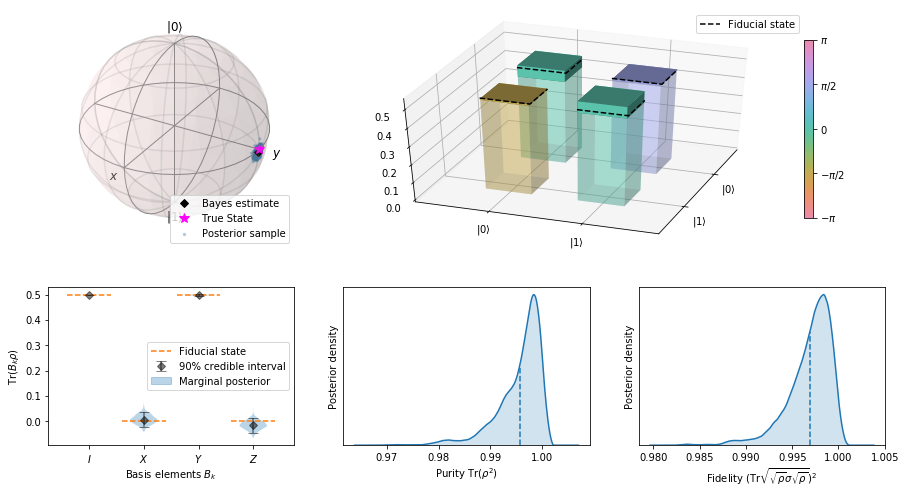

In [6]:
fig = plt.figure(figsize=(15, 8))
gs = mpl.gridspec.GridSpec(2,3, height_ratios=[3,2])

ax_bloch = plt.subplot(gs[0,0], projection='3d')
posterior.plot_bloch(axes=ax_bloch, fiducial_state=rho, fiducial_state_kwargs={'label': 'True State'})

ax_mat = plt.subplot(gs[0,1:3], projection='3d')
posterior.plot_matrix(axes=ax_mat, fiducial_state=rho)

ax_be = plt.subplot(gs[1,0])
posterior.plot_basis_expansion(bt.pauli_basis(), fiducial_state=rho)

ax_purity = plt.subplot(gs[1,1])
posterior.plot_purity()

ax_fidelity = plt.subplot(gs[1,2])
posterior.plot_fidelity(rho)

### Two Qubit Example

Everything is basically the same as above. We use the cat state as our true state, and we measure 15 combinations of Paulis offset by the identity.

In [55]:
psi = np.array([[1],[0],[0],[1]])/np.sqrt(2)
rho = np.dot(psi, psi.conj().T)

meas_ops = (bt.pauli_basis() + np.eye(2))/2
meas_ops = meas_ops.kron(meas_ops)[1:]

Generate the data with binomial sampling at 500 shots per measurement operator.

In [56]:
data = bt.BinomialTomographyData.simulate(rho, meas_ops, 5000)
print('measurement results: {}'.format(data.results))

measurement results: [2478 2542 2501 2506 2561 1234 1303 2502 1239    0 1222 2502 1239 1254
 2511]


Define the sampler and draw posterior samples.

In [57]:
sampler = bt.BinomialGinibreStateSampler(n_chains=4, ginibre_dim=2)
posterior = bt.StatePosterior(sampler, data)

In [58]:
sampler = bt.BinomialGinibreStateSampler(n_chains=4, ginibre_dim=2)
posterior = bt.StatePosterior(sampler, data)

Now let's make a few plots:

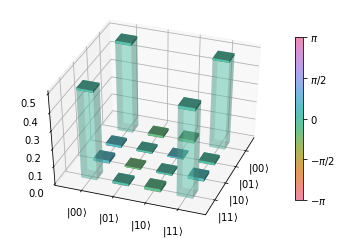

In [59]:
posterior.plot_matrix(vector_basis=bt.canonical_basis([2,2]))

(2, 16)


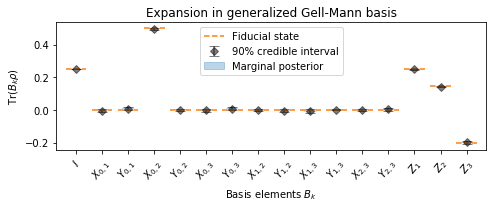

In [60]:
plt.figure(figsize=(7,3))
posterior.plot_basis_expansion(bt.gell_mann_basis(4), fiducial_state=rho)
plt.setp(plt.gca().xaxis.get_majorticklabels(), rotation=50) # rotate tick labels
plt.title('Expansion in generalized Gell-Mann basis')
plt.tight_layout()

(2, 16)


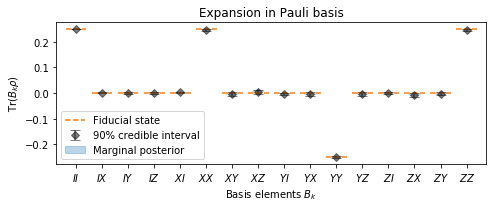

In [61]:
plt.figure(figsize=(7,3))
posterior.plot_basis_expansion(bt.pauli_basis(2), fiducial_state=rho)
plt.title('Expansion in Pauli basis')
plt.tight_layout()

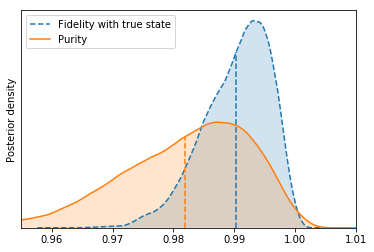

In [62]:
posterior.plot_fidelity(rho, label='Fidelity with true state', ls='--')
posterior.plot_purity(label='Purity')
plt.xlabel('')
plt.legend()

### Three qubit example

In [125]:
psi = np.zeros((2**4,1), dtype=np.complex)
psi[[0,-1]] = 1 / np.sqrt(2)
rho = np.dot(psi, psi.conj().T)

meas_ops = (bt.pauli_basis(4)[1:] + np.eye(psi.size)) / 2

In [126]:
data = bt.BinomialTomographyData.simulate(rho, meas_ops, 50000)
print('measurement results: {}'.format(data.results))

measurement results: [24977 25006 24936 25034 24955 25004 24940 25022 24954 25027 25069 25016
 25029 25204 50000 24989 25007 25056 24886 25045 24930 25034 24963 24835
 24945 25077 24938 25151 25183 25111 25151 25213 25009 24898 25119 24763
 24941 24925 25036 24887 25042 24936 25346 25075 25122 24799 25022 25141
 24998 25114 50000 24947 24952 25162 25052 24854 24950 25112 25034 50000
 24978 25107 24904 25107 25157 25068 24929 24964 24796 24913 25046 24885
 24910 25129 25332 25474 25036 25141 24896 24906 25107 24833 25085 25168
 50000 25095 25192 24987 24935     0 25055 25235 24915 25230 25153 24947
 24960 25138 25154 25051 25157     0 25034 25060     0 24956 25134 25013
 25150 25083 25011 24955 24938 25190 24908 25099 25249 24885 25229 25117
 24932 25204 24918 24875 25046 25006 25018 24881 24836 24993 24900 24972
 25028 25206 24887 24860 24872 24920 25128 25015 24872 25037 25118 25077
 25100 25046 24873 25106 25069     0 24952 25055     0 25055 24787 24898
 25024 24912 25095 24867 25159

In [127]:
sampler = bt.BinomialGinibreStateSampler(n_chains=4, ginibre_dim=1, n_iter=2000)
posterior = bt.StatePosterior(sampler, data)

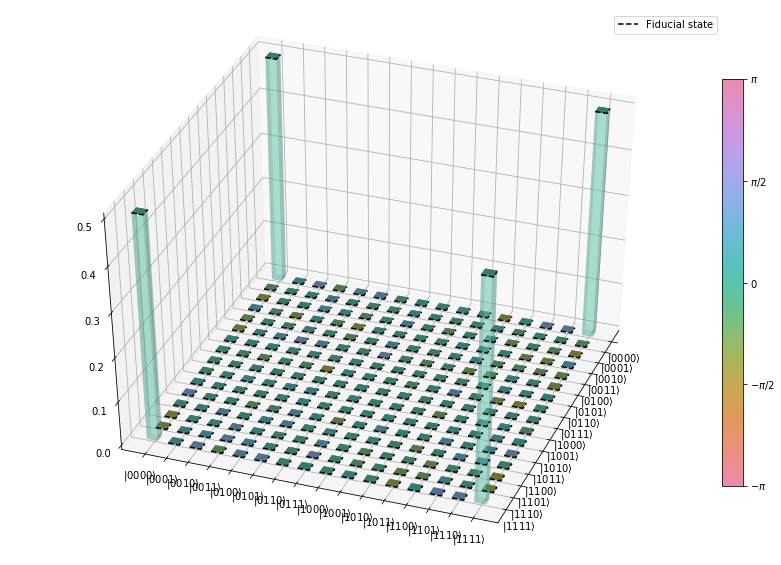

In [129]:
fig = plt.figure(figsize=(15,10))
posterior.plot_matrix(vector_basis=bt.canonical_basis([2,2,2,2]), fiducial_state=rho)